In [12]:
import torch
import matplotlib.pyplot as plt

import numpy as np
from sys import path
# path.insert(0,r"..\..\..\lib\deepxde")
import deepxde as dde
import BVP_function as bvp
import os

# import seaborn as sns
# sns.set_style("whitegrid") # better looking plots

print("Using GPU:", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)

from importlib import reload
import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = "white" # Set figure background to white for notebook with dark mode
dde.config.set_default_float('float64')

Using GPU: True
Set the default float type to float64


In [13]:
reload(bvp)

lmbd = torch.tensor(1.0)
mu = torch.tensor(0.5)

lmbd_trainable = dde.Variable(lmbd - 0.1)
mu_trainable = dde.Variable(mu + 0.1)
Q = 4.0

domain = np.array([[0.0, 1.0], [0.0, 1.0]])
geom = dde.geometry.Rectangle([0, 0], [1, 1])

phy_params = {'lmbd': lmbd, 'mu': mu, 'Q': Q}
phy_params_trainable = {'lmbd': lmbd_trainable, 'mu': mu_trainable, 'Q': Q}

#net parameters
net_type = ['Unet','USnet'][1]
n_layers = 4
size_layers = 50
activation = ['tanh','ReLU','Sigmoid'][0]

#loss parameters
loss_type = ['pde','energy'][0] #the energy loss appears to crash LBFGS and provide less accurate results with Adam. PDE loss is therefore used in the following
num_domain = 50**2
train_distribution = ['uniform','pseudo','LHS','Halton','Hammersley','Sobol'][4]

#boundary conditions
bc_type = ['soft','hard'][1]
num_boundary = 50

#optimizer
optimizers = ["adam","L-BFGS"]
learning_rates = [1e-3,None]
iterations = [3000,None]

config = {'net_type':net_type,'n_layers':n_layers,'size_layers':size_layers,'activation':activation,
        'loss_type':loss_type,'num_domain':num_domain,'train_distribution':train_distribution,
        'bc_type':bc_type,'num_boundary':num_boundary,
        'optimizers':optimizers,'learning_rates':learning_rates,'iterations':iterations}  

net_exact = bvp.set_exact_solution(net_type, phy_params,lib='np')

net = dde.nn.PFNN([2, [10]*5, [10]*5, [10]*5,[10]*5, 5], "tanh", "Glorot normal")
# net = dde.nn.FNN([2, 50 ,50 ,50 ,50 , 5], "sin", "Glorot normal")
net,total_loss,bc,pde_net,energy_net,mat_net = bvp.net_setup(net,net_type,bc_type,loss_type,geom,phy_params,phy_params_trainable=phy_params_trainable)

/home/dbey/pinn-cm/inverse/BVP_function.py:120: SyntaxWarning: invalid escape sequence '\m'
  subax[2].text(1.075,0.5,f"mean($\mid${fields_name[i]}_nn - {fields_name[i]}*$\mid$): {np.mean(abs_diff):.2e}", fontsize=6,ha = "center",rotation = "vertical",rotation_mode = "anchor")
/home/dbey/pinn-cm/inverse/BVP_function.py:120: SyntaxWarning: invalid escape sequence '\m'
  subax[2].text(1.075,0.5,f"mean($\mid${fields_name[i]}_nn - {fields_name[i]}*$\mid$): {np.mean(abs_diff):.2e}", fontsize=6,ha = "center",rotation = "vertical",rotation_mode = "anchor")


In [14]:
def generate_measures(domain, num_points, func, noise=0.0, seed=None):
    X = np.linspace(domain[0][0], domain[0][1], int(np.sqrt(num_points)))
    Y = np.linspace(domain[1][0], domain[1][1], int(np.sqrt(num_points)))
    Xgrid, Ygrid = np.meshgrid(X, Y)
    X_obs = np.hstack((Xgrid.reshape(-1, 1), Ygrid.reshape(-1, 1)))
    Yexact = func(X_obs)
    Y_obs = Yexact# + noise * np.random.randn(*Yexact.shape)
    return X_obs, Y_obs

# generate training data
S_exact = lambda X: bvp.S_exact(X,phy_params)
U_exact = lambda X: bvp.U_exact(X,phy_params)

X_obs, U_obs = generate_measures(domain, 1000, U_exact, noise=0.0)
X_obs, S_obs = generate_measures(domain, 1000, S_exact, noise=0.0)


observe_Ux = dde.PointSetBC(X_obs, U_obs[:, 0:1], component=0)
observe_Uy = dde.PointSetBC(X_obs, U_obs[:, 1:2], component=1)

observe_Sx = dde.PointSetBC(X_obs, S_obs[0].reshape(-1, 1), component=2)
observe_Sy = dde.PointSetBC(X_obs, S_obs[1].reshape(-1, 1), component=3)
observe_Sxy = dde.PointSetBC(X_obs, S_obs[2].reshape(-1, 1), component=4)



# material_behavior = dde.icbc.OperatorBC()
bc += [observe_Ux, observe_Uy]
bc += [observe_Sx, observe_Sy, observe_Sxy]

# sanity check that BCs are enforced
# U_output = lambda x, ouput: (ouput[:,0], ouput[:,1]) 
# S_output = lambda x, ouput: bvp.S_nn(bvp.E_nn(x,ouput),phy_params_trainable) if config['net_type'] == 'Unet' else (ouput[:,2], ouput[:,3], ouput[:,4]) 

# fig = bvp.plot_field(domain,model,output_func=U_output,V_exact=lambda x: (U_exact(x)[:,0], U_exact(x)[:,1]),plot_diff=True,fields_name="U")
# fig = bvp.plot_field(domain,model,output_func=S_output,V_exact=S_exact,plot_diff=True,fields_name="S")

In [6]:
# train U subnetwork on ground truth U
data = dde.data.Function(
    geom,
    U_exact,
    num_train=100**2,
    num_test=1000,
    train_distribution="uniform"
)

def output_U_train(x,net_output):
    Ux = net_output[:,0]*x[:,1]*(1-x[:,1])
    Uy = net_output[:,1]*x[:,0]*(1-x[:,0])*x[:,1]
    return torch.hstack((Ux.reshape(-1,1),Uy.reshape(-1,1))) 

net.apply_output_transform(output_U_train)

net.freeze_subnetworks([2,3,4])
model = dde.Model(data, net)

model.compile("adam", lr=1e-3, metrics=["l2 relative error"])#,loss_weights=loss_weights)
losshistory, train_state = model.train(iterations=5000)

# U_output = lambda x, ouput: (ouput[:,0], ouput[:,1]) 
# fig = bvp.plot_field(domain,model,output_func=U_output,V_exact=lambda x: (U_exact(x)[:,0], U_exact(x)[:,1]),plot_diff=True,fields_name="U")


Compiling model...
'compile' took 0.000810 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.56e-01]    [1.57e-01]    [1.01e+00]    
1000      [2.09e-04]    [2.35e-04]    [3.89e-02]    
2000      [7.65e-05]    [9.30e-05]    [2.45e-02]    
3000      [7.56e-05]    [8.39e-05]    [2.33e-02]    
4000      [3.00e-05]    [3.87e-05]    [1.58e-02]    
5000      [2.09e-05]    [2.80e-05]    [1.34e-02]    

Best model at step 5000:
  train loss: 2.09e-05
  test loss: 2.80e-05
  test metric: [1.34e-02]

'train' took 98.342883 s



In [15]:
def HardBC_USnet(x,net_output):
    lmbd, mu, Q = phy_params["lmbd"], phy_params["mu"], phy_params["Q"]

    Ux = net_output[:,0]*x[:,1]*(1-x[:,1])
    Uy = net_output[:,1]*x[:,0]*(1-x[:,0])*x[:,1]

    Sxx = net_output[:,2]*x[:,0]*(1-x[:,0])
    Syy = net_output[:,3]*(1-x[:,1]) + (lmbd + 2*mu)*Q*torch.sin(torch.pi*x[:,0])
    Sxy = net_output[:,4] 
    return torch.hstack((Ux.reshape(-1,1),Uy.reshape(-1,1),Sxx.reshape(-1,1),Syy.reshape(-1,1),Sxy.reshape(-1,1))) 

net.apply_output_transform(HardBC_USnet)
net.freeze_subnetworks([0,1])

trainable_variables = [lmbd_trainable, mu_trainable]
variable = dde.callbacks.VariableValue(trainable_variables, period=1000, filename="elasticity_param.dat")
fname = "saved_model"
loss_weights = [1]*2+[1]+[0]*2+[0]*3 #PDE, Material, U_obs, S_obs

num_domain = 100**2

data = dde.data.PDE(
    geom,
    total_loss,
    bc,
    num_domain=num_domain,
    num_boundary=num_boundary,
    num_test= num_domain,
    train_distribution = train_distribution,
    solution=net_exact,
)
model = dde.Model(data, net)

print(f"lambda:{lmbd_trainable:.3f}|{lmbd:.2f}; mu: {mu_trainable:.3f}|{mu:.2f}")

# model.compile("adam", lr=1e-2, metrics=["l2 relative error"])#,loss_weights=loss_weights)
# # model.restore(os.path.join(fname,"USnet_lmbd-1.0_mu-0.5-12000.pt"),device=device)
# losshistory, train_state = model.train(iterations=10000,display_every=1000)
# print(f"lambda:{lmbd_trainable:.3f}|{lmbd:.2f}; mu: {mu_trainable:.3f}|{mu:.2f}")

# model.compile("adam", lr=0.001, external_trainable_variables=trainable_variables, metrics=["l2 relative error"],loss_weights=loss_weights)
# losshistory, train_state = model.train(iterations=1000,display_every=100, callbacks=[variable])
# print(f"lambda:{lmbd_trainable:.3f}|{lmbd:.2f}; mu: {mu_trainable:.3f}|{mu:.2f}")

# train lbfgs
model.compile("L-BFGS", metrics=["l2 relative error"], external_trainable_variables=trainable_variables,loss_weights=loss_weights)
losshistory, train_state = model.train()#callbacks=[variable])#,display_every=100,batch_size=100)
print(f"lambda:{lmbd_trainable:.3f}|{lmbd:.2f}; mu: {mu_trainable:.3f}|{mu:.2f}")

lambda:0.900|1.00; mu: 0.600|0.50
Compiling model...
'compile' took 0.000752 s



/home/dbey/miniconda3/envs/torch/lib/python3.12/site-packages/skopt/space/space.py:111: UserWarning: Dimension (0.0, 1.0) was inferred to Real(low=0.0, high=1.0, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to <TypeError: Real.__init__() got an unexpected keyword argument 'tranform'>. See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
/home/dbey/miniconda3/envs/torch/lib/python3.12/site-packages/skopt/space/space.py:111: UserWarning: Dimension (0.0, 1.0) was inferred to Real(low=0.0, high=1.0, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to <TypeError: Real.__init__() got an unexpected keyword argument 'tranform'>. See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
/home/dbey/miniconda3/envs/torch/lib/python3.12/site-packages/skopt/space/space.py:111: UserWarning: Dimension (0.0, 1.0) was infe

Training model...



RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

In [32]:
print(f"lambda:{lmbd_trainable:.3f}|{lmbd:.2f}; mu: {mu_trainable:.3f}|{mu:.2f}")

lambda:0.493|1.00; mu: 0.671|0.50


In [9]:
print(f"lambda:{phy_params_trainable['lmbd']:.4f}|{lmbd:.2f}; mu: {phy_params_trainable['mu']:.4f}|{mu:.2f}")

lambda:1.4810|1.00; mu: 0.1573|0.50


In [30]:
fname = "saved_model"
save_run = True
if save_run:
    model.compile("adam", lr=0.01, external_trainable_variables=trainable_variables, metrics=["l2 relative error"],loss_weights=loss_weights)
    model.train(iterations=0,model_save_path=os.path.join(fname, f"{net_type}_lmbd-{lmbd}_mu-{mu}"))

Compiling model...
'compile' took 0.001266 s

Training model...

10397     [1.42e-02, 4.13e-02, 5.60e-02, 5.12e-05, 3.46e-06, 0.00e+00, 0.00e+00, 0.00e+00]    [1.27e-02, 3.66e-02, 3.46e-02, 5.12e-05, 3.46e-06, 0.00e+00, 0.00e+00, 0.00e+00]    [6.67e-01]    

Best model at step 3000:
  train loss: 4.46e-02
  test loss: 2.57e-02
  test metric: [6.80e-01]

Epoch 10397: saving model to saved_model\USnet_lmbd-1.0_mu-0.5-10397.pt ...

'train' took 0.118450 s



In [24]:
f"{net_type}_lmbd-{lmbd}_mu-{mu}"

'USnet_lmbd-1.0_mu-0.5'

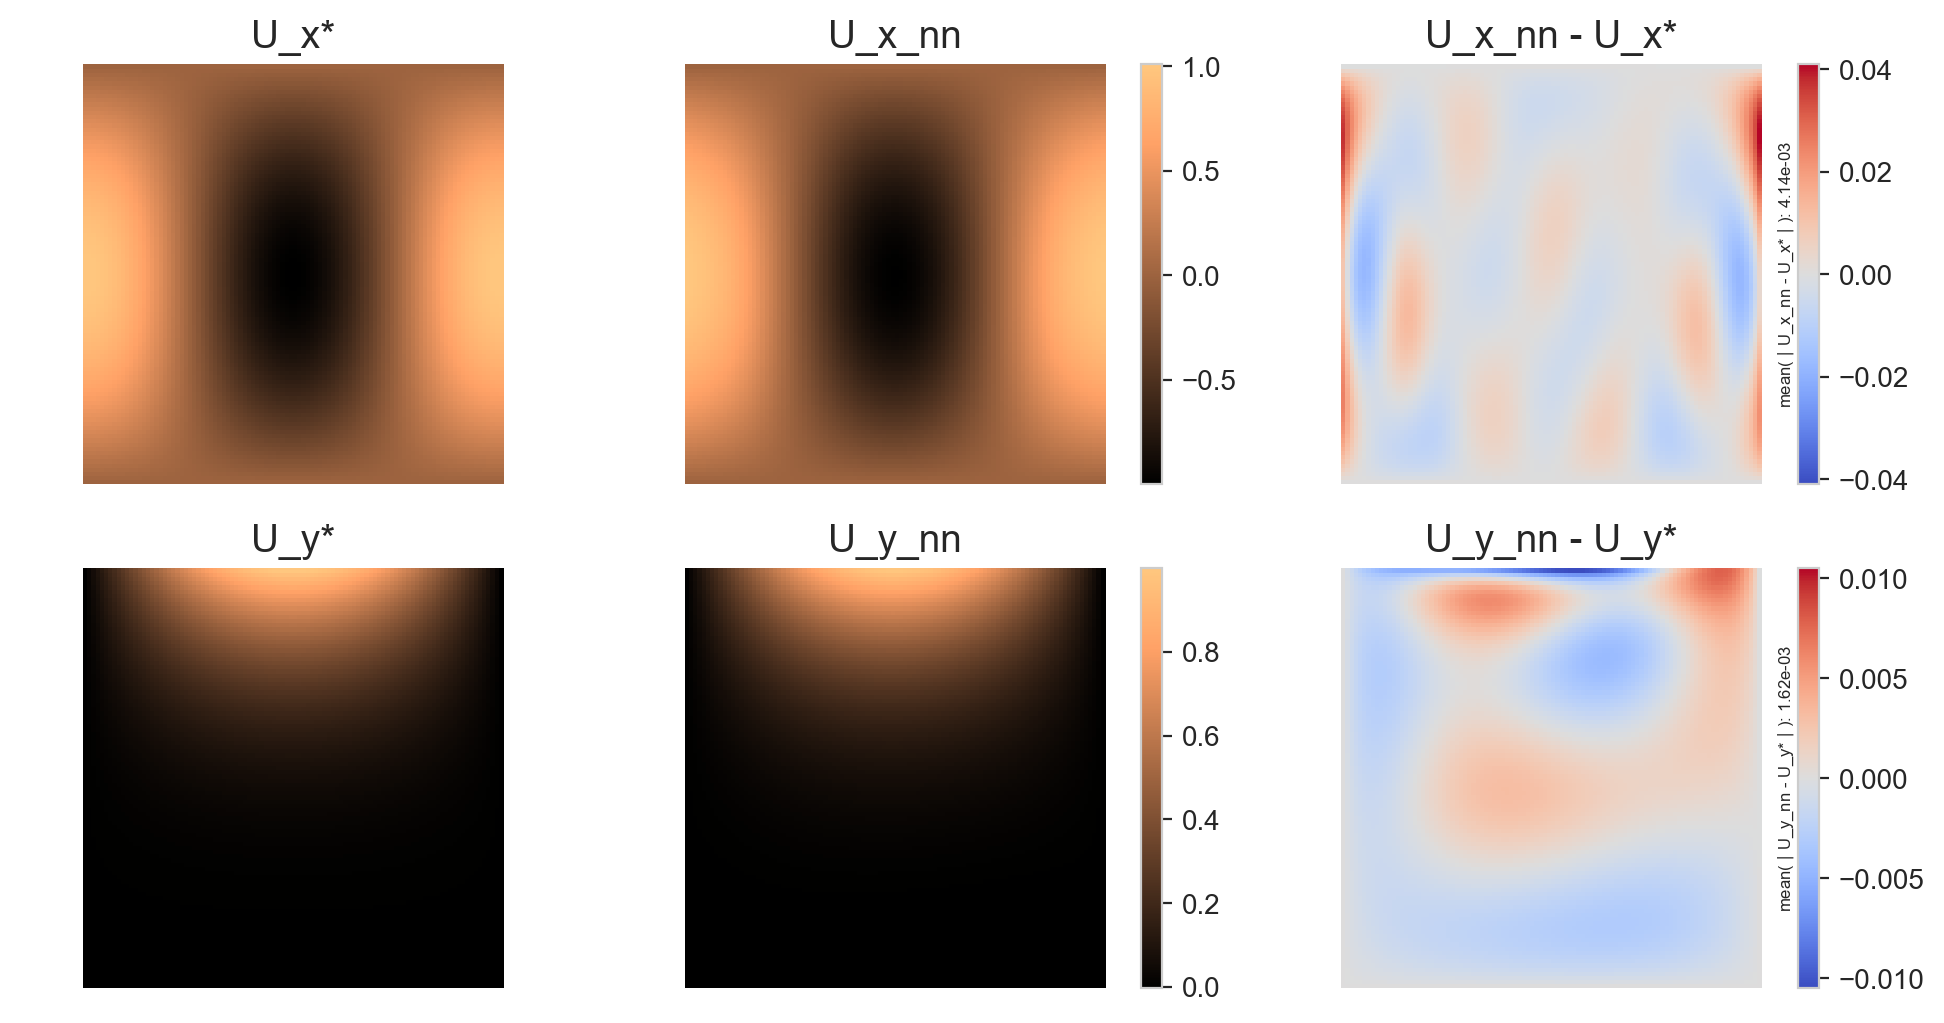

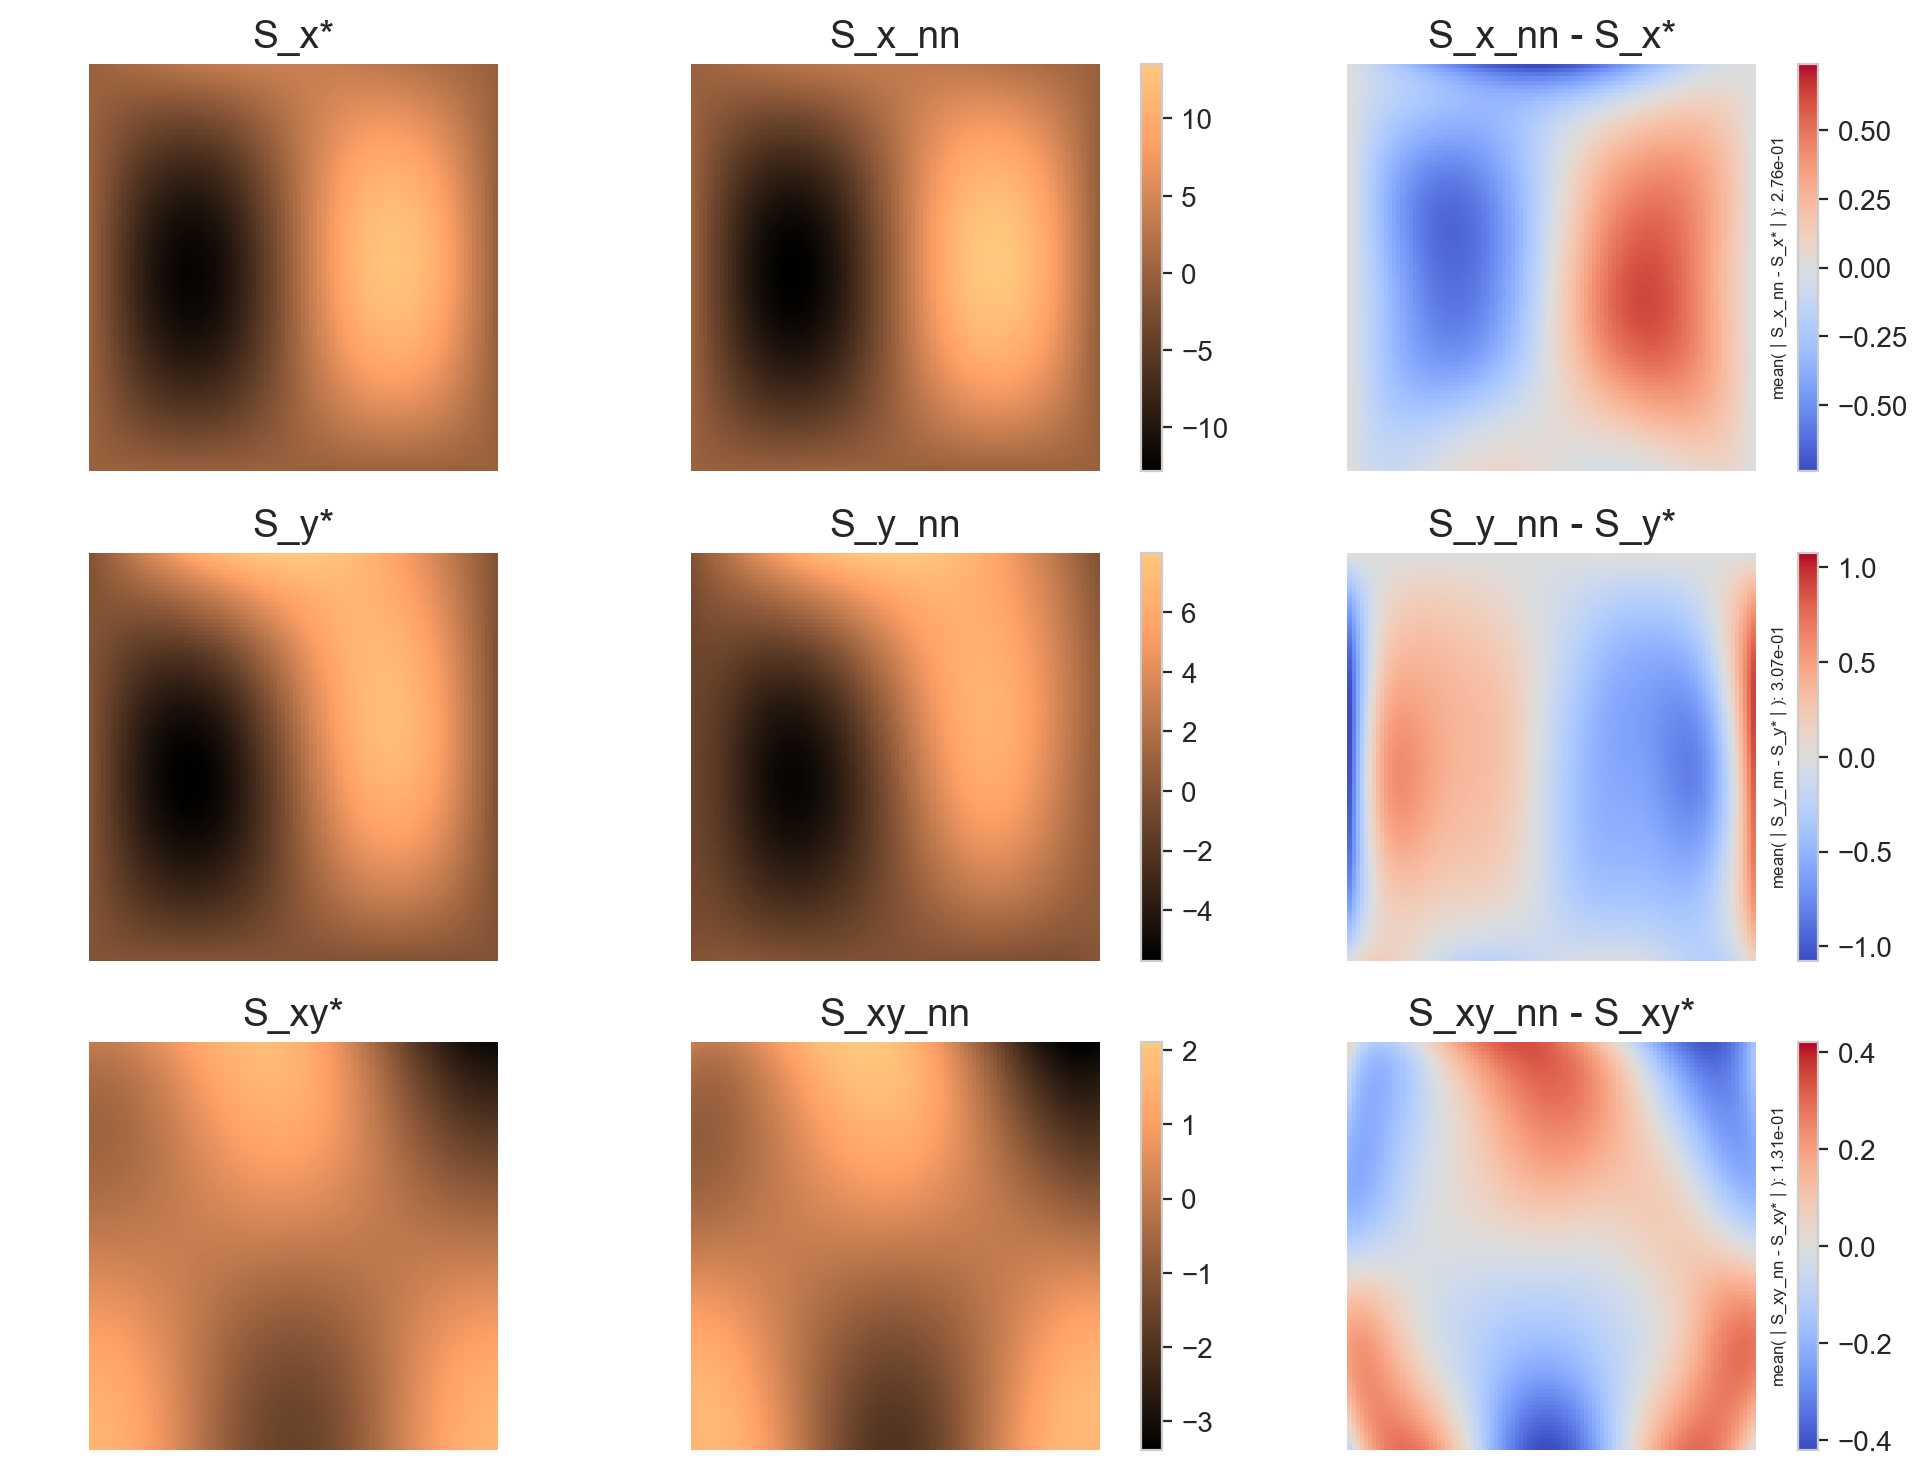

In [44]:
S_exact = lambda X: bvp.S_exact(X,phy_params)
U_output = lambda x, ouput: (ouput[:,0], ouput[:,1]) 
S_output = lambda x, ouput: bvp.S_nn(bvp.E_nn(x,ouput),phy_params_trainable) if config['net_type'] == 'Unet' else (ouput[:,2], ouput[:,3], ouput[:,4]) 

fig = bvp.plot_field(domain,model,output_func=U_output,V_exact=lambda x: (U_exact(x)[:,0], U_exact(x)[:,1]),plot_diff=True,fields_name="U")
fig = bvp.plot_field(domain,model,output_func=S_output,V_exact=S_exact,plot_diff=True,fields_name="S")

In [45]:
print(phy_params_trainable)
print(phy_params)

{'lmbd': tensor(0.9000, requires_grad=True), 'mu': tensor(0.6000, requires_grad=True), 'Q': 4.0}
{'lmbd': tensor(1.), 'mu': tensor(0.5000), 'Q': 4.0}
